In [10]:

!pip install tensorflow==2.15.1



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [11]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications.vgg19 import VGG19
import numpy as np
import time
import gc


In [12]:
print(tf.__version__)

2.15.1


In [13]:
device_name = tf.test.gpu_device_name()

if "GPU" not in device_name:
    print("GPU device not found")
    
print('Found GPU at: {}'.format(device_name))

print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

Found GPU at: /device:GPU:0
GPU available (YESS!!!!)


2025-01-07 02:54:55.068635: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-07 02:54:55.068655: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications.vgg19 import VGG19
import numpy as np

class ESRGAN:
    def __init__(self, scale_factor=4):
        self.scale_factor = scale_factor
        self.generator = None
        self.discriminator = None
        self.vgg = None
        self.build_models()
        
    def residual_dense_block(self, x, features=32):
        """Residual Dense Block without tf.function decorator"""
        class RDB(layers.Layer):
            def __init__(self, features=32):
                super(RDB, self).__init__()
                self.features = features
                self.conv_layers = [
                    layers.Conv2D(features, (3, 3), padding='same') 
                    for _ in range(3)
                ]
                self.lrelu = layers.LeakyReLU(0.2)
                self.final_conv = layers.Conv2D(features, (1, 1), padding='same')
                
            def call(self, x):
                inputs = x
                concat_features = []
                
                for conv in self.conv_layers:
                    if concat_features:
                        x = layers.Concatenate()(concat_features + [x])
                    x = conv(x)
                    x = self.lrelu(x)
                    concat_features.append(x)
                
                x = layers.Concatenate()(concat_features)
                x = self.final_conv(x)
                return layers.Add()([inputs, x * 0.2])
                
        return RDB(features)(x)
    
    def rrdb_block(self, x, features=32):
        """Residual in Residual Dense Block"""
        class RRDB(layers.Layer):
            def __init__(self, features=32):
                super(RRDB, self).__init__()
                self.features = features
                self.rdbs = [RDB(features) for _ in range(3)]
                
            def call(self, x):
                inputs = x
                for rdb in self.rdbs:
                    x = rdb(x)
                return layers.Add()([inputs, x * 0.2])
                
        return RRDB(features)(x)
    
    def build_models(self):
        # Generator
        lr_input = Input(shape=(None, None, 1))
        
        # Initial features
        x = layers.Conv2D(32, (3, 3), padding='same')(lr_input)
        initial_feature = x
        
        # RRDB blocks
        for _ in range(8):  # Reduced number of blocks
            x = self.residual_dense_block(x)
        
        # Global feature fusion
        x = layers.Conv2D(32, (3, 3), padding='same')(x)
        trunk = layers.Add()([initial_feature, x])
        
        # Upsampling blocks
        x = layers.Conv2D(128, (3, 3), padding='same')(trunk)
        x = tf.nn.depth_to_space(x, 2)
        x = layers.LeakyReLU(0.2)(x)
        
        x = layers.Conv2D(128, (3, 3), padding='same')(x)
        x = tf.nn.depth_to_space(x, 2)
        x = layers.LeakyReLU(0.2)(x)
        
        sr_output = layers.Conv2D(1, (3, 3), padding='same', activation='tanh')(x)
        
        self.generator = Model(lr_input, sr_output, name='generator')
        
        # Discriminator
        d_input = Input(shape=(None, None, 1))
        
        features = [32, 32, 64, 64, 128, 128]
        x = d_input
        
        for idx, f in enumerate(features):
            x = layers.Conv2D(f, (3, 3), strides=2 if idx % 2 == 1 else 1, padding='same')(x)
            x = layers.BatchNormalization()(x)
            x = layers.LeakyReLU(0.2)(x)
        
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(512)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.Dense(1, activation='sigmoid')(x)
        
        self.discriminator = Model(d_input, x, name='discriminator')
        
        # VGG feature extractor
        vgg = VGG19(include_top=False, weights='imagenet')
        self.vgg = Model(inputs=vgg.input,
                        outputs=vgg.get_layer('block5_conv4').output,
                        name='vgg')
        self.vgg.trainable = False
    
    def compile(self, gen_lr=1e-4, disc_lr=1e-4,
                content_weight=1.0, perceptual_weight=1.0, adversarial_weight=0.1):
        self.gen_optimizer = tf.keras.optimizers.Adam(gen_lr, beta_1=0.9)
        self.disc_optimizer = tf.keras.optimizers.Adam(disc_lr, beta_1=0.9)
        self.content_weight = content_weight
        self.perceptual_weight = perceptual_weight
        self.adversarial_weight = adversarial_weight
    
    @tf.function
    def train_step(self, lr_images, hr_images):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Generate fake images
            sr_images = self.generator(lr_images, training=True)
            
            # Discriminator outputs
            real_output = self.discriminator(hr_images, training=True)
            fake_output = self.discriminator(sr_images, training=True)
            
            # Content loss
            content_loss = tf.reduce_mean(tf.abs(hr_images - sr_images))
            
            # Perceptual loss
            hr_features = self.vgg(tf.repeat(hr_images, repeats=3, axis=-1))
            sr_features = self.vgg(tf.repeat(sr_images, repeats=3, axis=-1))
            perceptual_loss = tf.reduce_mean(tf.abs(hr_features - sr_features))
            
            # Adversarial loss
            disc_loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(
                    labels=tf.ones_like(real_output), logits=real_output
                ) +
                tf.nn.sigmoid_cross_entropy_with_logits(
                    labels=tf.zeros_like(fake_output), logits=fake_output
                )
            )
            
            gen_loss = self.adversarial_weight * tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(
                    labels=tf.ones_like(fake_output), logits=fake_output
                )
            )
            
            # Total generator loss
            total_gen_loss = (
                self.content_weight * content_loss +
                self.perceptual_weight * perceptual_loss +
                gen_loss
            )
        
        # Compute and apply gradients
        gen_gradients = gen_tape.gradient(
            total_gen_loss, self.generator.trainable_variables
        )
        disc_gradients = disc_tape.gradient(
            disc_loss, self.discriminator.trainable_variables
        )
        
        self.gen_optimizer.apply_gradients(
            zip(gen_gradients, self.generator.trainable_variables)
        )
        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.discriminator.trainable_variables)
        )
        
        return {
            'content_loss': content_loss,
            'perceptual_loss': perceptual_loss,
            'gen_loss': gen_loss,
            'disc_loss': disc_loss,
            'total_gen_loss': total_gen_loss
        }

In [15]:
class DataLoader:
    def __init__(self, image_dir, batch_size=4, hr_size=512, lr_size=128):
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.hr_size = hr_size
        self.lr_size = lr_size
        self.scale_factor = hr_size // lr_size
        self.dataset = self._create_dataset()
    
    def _load_and_process(self, path):
        # Load and decode image
        img = tf.io.read_file(path)
        img = tf.image.decode_png(img, channels=1)
        img = tf.cast(img, tf.float32)
        
        # Normalize to [-1, 1] range
        img = (img - 127.5) / 127.5
        
        # Create high-res version (512x512)
        hr_img = tf.image.resize(img, [self.hr_size, self.hr_size],
                               method='bicubic')
        
        # Create low-res version (128x128)
        lr_img = tf.image.resize(img, [self.lr_size, self.lr_size],
                               method='bicubic')
        
        # Add random noise to prevent overfitting
        noise = tf.random.normal(lr_img.shape, mean=0.0, stddev=0.01)
        lr_img = tf.clip_by_value(lr_img + noise, -1.0, 1.0)
        
        return lr_img, hr_img
    
    def _create_dataset(self):
        # List all image files
        image_paths = tf.data.Dataset.list_files(str(self.image_dir + '/*'))
        
        # Create dataset with shuffling and prefetching
        dataset = (image_paths
                  .shuffle(1000)
                  .map(self._load_and_process, 
                       num_parallel_calls=tf.data.AUTOTUNE)
                  .batch(self.batch_size)
                  .prefetch(tf.data.AUTOTUNE))
        
        return dataset
# Initialize model
# model = ESRGAN(scale_factor=4)

In [16]:
import tensorflow as tf
import numpy as np
import time
import gc

# Set GPU memory growth at the very beginning
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(f"Error setting GPU memory growth: {e}")

def train_esrgan(model, data_loader, epochs=100, save_interval=5):
    """Training function for ESRGAN"""
    # Create directories for saving
    os.makedirs('esrgan_models', exist_ok=True)
    os.makedirs('esrgan_samples', exist_ok=True)
    
    # Initialize history dictionary
    history = {
        'content_loss': [],
        'perceptual_loss': [],
        'gen_loss': [],
        'disc_loss': [],
        'total_gen_loss': []
    }
    
    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        start_time = time.time()
        
        # Initialize epoch metrics
        epoch_losses = {
            'content_loss': [],
            'perceptual_loss': [],
            'gen_loss': [],
            'disc_loss': [],
            'total_gen_loss': []
        }
        
        for batch_idx, (lr_images, hr_images) in enumerate(data_loader.dataset):
            # Clear memory periodically
            if batch_idx % 50 == 0:
                gc.collect()
            
            try:
                # Perform training step
                losses = model.train_step(lr_images, hr_images)
                
                # Append batch losses
                for key in epoch_losses.keys():
                    epoch_losses[key].append(float(losses[key]))
                
                # Print progress
                if (batch_idx + 1) % 20 == 0:
                    print(f"Batch {batch_idx + 1} - "
                          f"Content: {losses['content_loss']:.4f}, "
                          f"Perceptual: {losses['perceptual_loss']:.4f}, "
                          f"Gen: {losses['gen_loss']:.4f}, "
                          f"Disc: {losses['disc_loss']:.4f}")
                    
            except tf.errors.ResourceExhaustedError:
                print("GPU memory exhausted, skipping batch...")
                gc.collect()
                continue
                
            except Exception as e:
                print(f"Error in batch {batch_idx}: {str(e)}")
                continue
        
        # Calculate epoch averages
        for key in history.keys():
            avg_loss = np.mean(epoch_losses[key])
            history[key].append(avg_loss)
        
        # Print epoch summary
        epoch_time = time.time() - start_time
        print(f"\nEpoch {epoch + 1} Summary:")
        print(f"Time: {epoch_time:.2f}s")
        print(f"Content Loss: {history['content_loss'][-1]:.4f}")
        print(f"Perceptual Loss: {history['perceptual_loss'][-1]:.4f}")
        print(f"Generator Loss: {history['gen_loss'][-1]:.4f}")
        print(f"Discriminator Loss: {history['disc_loss'][-1]:.4f}")
        
        # Save model periodically
        if (epoch + 1) % save_interval == 0:
            save_checkpoint(model, epoch + 1, history)
            
    return history

def save_checkpoint(model, epoch, history):
    """Save model checkpoint and training history"""
    try:
        # Save generator
        model.generator.save(f'esrgan_models/generator_epoch_{epoch}.h5')
        
        # Save discriminator
        model.discriminator.save(f'esrgan_models/discriminator_epoch_{epoch}.h5')
        
        # Save history
        np.save(f'esrgan_models/history_epoch_{epoch}.npy', history)
        
        print(f"Checkpoint saved for epoch {epoch}")
    except Exception as e:
        print(f"Error saving checkpoint: {e}")

GPU memory growth enabled


In [17]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import os

class ESRGANVisualizer:
    def __init__(self, save_dir='esrgan_visualizations'):
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
        
    def plot_training_history(self, history):
        """Plot and save training metrics over time."""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Create a figure with multiple subplots
        fig = plt.figure(figsize=(20, 12))
        
        # Plot individual losses
        plt.subplot(2, 2, 1)
        plt.plot(history['content_loss'], label='Content Loss', color='blue')
        plt.plot(history['perceptual_loss'], label='Perceptual Loss', color='green')
        plt.title('Content and Perceptual Losses')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        # Plot generator and discriminator losses
        plt.subplot(2, 2, 2)
        plt.plot(history['gen_loss'], label='Generator Loss', color='red')
        plt.plot(history['disc_loss'], label='Discriminator Loss', color='purple')
        plt.title('Adversarial Losses')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        # Plot total generator loss
        plt.subplot(2, 2, 3)
        plt.plot(history['total_gen_loss'], label='Total Generator Loss', color='orange')
        plt.title('Total Generator Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        # Plot loss ratios
        plt.subplot(2, 2, 4)
        content_to_perceptual = np.array(history['content_loss']) / (np.array(history['perceptual_loss']) + 1e-8)
        gen_to_disc = np.array(history['gen_loss']) / (np.array(history['disc_loss']) + 1e-8)
        
        plt.plot(content_to_perceptual, label='Content/Perceptual Ratio', color='cyan')
        plt.plot(gen_to_disc, label='Generator/Discriminator Ratio', color='magenta')
        plt.title('Loss Ratios')
        plt.xlabel('Epoch')
        plt.ylabel('Ratio')
        plt.legend()
        plt.grid(True)
        
        # Add overall title
        plt.suptitle('ESRGAN Training Metrics', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Save the plot
        plt.savefig(os.path.join(self.save_dir, f'training_history_{timestamp}.png'))
        plt.show()
        
    
    def create_training_summary(self, history):
        """Create and save a summary of training statistics."""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        summary = {
            'total_epochs': len(history['content_loss']),
            'final_losses': {
                k: v[-1] for k, v in history.items()
            },
            'best_epoch': {
                k: np.argmin(v) + 1 for k, v in history.items()
            },
            'improvement_rate': {
                k: (v[0] - v[-1]) / (v[0] + 1e-8) * 100 for k, v in history.items()
            }
        }
        
        # Save summary to text file
        with open(os.path.join(self.save_dir, f'training_summary_{timestamp}.txt'), 'w') as f:
            f.write('ESRGAN Training Summary\n')
            f.write('======================\n\n')
            
            f.write(f"Total Epochs: {summary['total_epochs']}\n\n")
            
            f.write('Final Losses:\n')
            for k, v in summary['final_losses'].items():
                f.write(f"  {k}: {v:.4f}\n")
            
            f.write('\nBest Performing Epochs:\n')
            for k, v in summary['best_epoch'].items():
                f.write(f"  {k}: Epoch {v}\n")
            
            f.write('\nImprovement Rates:\n')
            for k, v in summary['improvement_rate'].items():
                f.write(f"  {k}: {v:.2f}%\n")
        
        return summary


Epoch 1/50


2025-01-07 02:54:57.963321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-01-07 02:54:58.271751: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


Batch 20 - Content: 0.2124, Perceptual: 0.1020, Gen: 0.0581, Disc: 1.3731
Batch 40 - Content: 0.1349, Perceptual: 0.0968, Gen: 0.0626, Disc: 1.3651
Batch 60 - Content: 0.1089, Perceptual: 0.1007, Gen: 0.0624, Disc: 1.3553
Batch 80 - Content: 0.1117, Perceptual: 0.0889, Gen: 0.0630, Disc: 1.3181
Batch 100 - Content: 0.1033, Perceptual: 0.0836, Gen: 0.0630, Disc: 1.2507
Batch 120 - Content: 0.0964, Perceptual: 0.0795, Gen: 0.0639, Disc: 1.1844
Batch 140 - Content: 0.0875, Perceptual: 0.0847, Gen: 0.0646, Disc: 1.1214
Batch 160 - Content: 0.0763, Perceptual: 0.0869, Gen: 0.0661, Disc: 1.1698
Batch 180 - Content: 0.0653, Perceptual: 0.0845, Gen: 0.0673, Disc: 1.1266
Batch 200 - Content: 0.0737, Perceptual: 0.0717, Gen: 0.0669, Disc: 1.0672
Batch 220 - Content: 0.0835, Perceptual: 0.0760, Gen: 0.0538, Disc: 1.2078
Batch 240 - Content: 0.0622, Perceptual: 0.0645, Gen: 0.0661, Disc: 1.2203
Batch 260 - Content: 0.0857, Perceptual: 0.0743, Gen: 0.0633, Disc: 1.1988
Batch 280 - Content: 0.0663, 

/Users/osama/.pyenv/versions/3.9.20/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Checkpoint saved for epoch 5

Epoch 6/50
Batch 20 - Content: 0.0357, Perceptual: 0.0425, Gen: 0.0693, Disc: 1.0064
Batch 40 - Content: 0.0468, Perceptual: 0.0345, Gen: 0.0693, Disc: 1.0064
Batch 60 - Content: 0.0509, Perceptual: 0.0336, Gen: 0.0693, Disc: 1.0065
Batch 80 - Content: 0.0513, Perceptual: 0.0516, Gen: 0.0693, Disc: 1.0066
Batch 100 - Content: 0.0520, Perceptual: 0.0438, Gen: 0.0693, Disc: 1.0065
Batch 120 - Content: 0.0437, Perceptual: 0.0357, Gen: 0.0693, Disc: 1.0064
Batch 140 - Content: 0.0463, Perceptual: 0.0315, Gen: 0.0693, Disc: 1.0064
Batch 160 - Content: 0.0490, Perceptual: 0.0402, Gen: 0.0693, Disc: 1.0065
Batch 180 - Content: 0.0496, Perceptual: 0.0366, Gen: 0.0693, Disc: 1.0065
Batch 200 - Content: 0.0425, Perceptual: 0.0364, Gen: 0.0693, Disc: 1.0065
Batch 220 - Content: 0.0468, Perceptual: 0.0386, Gen: 0.0693, Disc: 1.0076
Batch 240 - Content: 0.0493, Perceptual: 0.0382, Gen: 0.0693, Disc: 1.0066
Batch 260 - Content: 0.0458, Perceptual: 0.0301, Gen: 0.0693, D

Checkpoint saved for epoch 10

Epoch 11/50
Batch 20 - Content: 0.0454, Perceptual: 0.0260, Gen: 0.0693, Disc: 1.0064
Batch 40 - Content: 0.0425, Perceptual: 0.0308, Gen: 0.0693, Disc: 1.0064
Batch 60 - Content: 0.0526, Perceptual: 0.0337, Gen: 0.0693, Disc: 1.0064
Batch 80 - Content: 0.0427, Perceptual: 0.0331, Gen: 0.0693, Disc: 1.0064
Batch 100 - Content: 0.0478, Perceptual: 0.0371, Gen: 0.0693, Disc: 1.0064
Batch 120 - Content: 0.0362, Perceptual: 0.0326, Gen: 0.0693, Disc: 1.0064
Batch 140 - Content: 0.0422, Perceptual: 0.0280, Gen: 0.0693, Disc: 1.0064
Batch 160 - Content: 0.0341, Perceptual: 0.0412, Gen: 0.0693, Disc: 1.0064
Batch 180 - Content: 0.0434, Perceptual: 0.0391, Gen: 0.0693, Disc: 1.0064
Batch 200 - Content: 0.0488, Perceptual: 0.0392, Gen: 0.0693, Disc: 1.0064
Batch 220 - Content: 0.0429, Perceptual: 0.0296, Gen: 0.0693, Disc: 1.0064
Batch 240 - Content: 0.0481, Perceptual: 0.0392, Gen: 0.0693, Disc: 1.0064
Batch 260 - Content: 0.0523, Perceptual: 0.0358, Gen: 0.0693,

Checkpoint saved for epoch 15

Epoch 16/50
Batch 20 - Content: 0.0481, Perceptual: 0.0343, Gen: 0.0693, Disc: 1.3863
Batch 40 - Content: 0.0402, Perceptual: 0.0358, Gen: 0.0693, Disc: 1.3863
Batch 60 - Content: 0.0406, Perceptual: 0.0396, Gen: 0.0693, Disc: 1.3863
Batch 80 - Content: 0.0359, Perceptual: 0.0391, Gen: 0.0693, Disc: 1.3863
Batch 100 - Content: 0.0408, Perceptual: 0.0381, Gen: 0.0693, Disc: 1.3863
Batch 120 - Content: 0.0403, Perceptual: 0.0338, Gen: 0.0693, Disc: 1.3863
Batch 140 - Content: 0.0422, Perceptual: 0.0341, Gen: 0.0693, Disc: 1.3863
Batch 160 - Content: 0.0348, Perceptual: 0.0270, Gen: 0.0693, Disc: 1.3863
Batch 180 - Content: 0.0404, Perceptual: 0.0303, Gen: 0.0693, Disc: 1.3863
Batch 200 - Content: 0.0452, Perceptual: 0.0338, Gen: 0.0693, Disc: 1.3863
Batch 220 - Content: 0.0346, Perceptual: 0.0325, Gen: 0.0693, Disc: 1.3863
Batch 240 - Content: 0.0318, Perceptual: 0.0288, Gen: 0.0693, Disc: 1.3863
Batch 260 - Content: 0.0388, Perceptual: 0.0339, Gen: 0.0693,

Checkpoint saved for epoch 20

Epoch 21/50
Batch 20 - Content: 0.0470, Perceptual: 0.0367, Gen: 0.0693, Disc: 1.3863
Batch 40 - Content: 0.0468, Perceptual: 0.0312, Gen: 0.0693, Disc: 1.3863
Batch 60 - Content: 0.0468, Perceptual: 0.0378, Gen: 0.0693, Disc: 1.3863
Batch 80 - Content: 0.0422, Perceptual: 0.0355, Gen: 0.0693, Disc: 1.3863
Batch 100 - Content: 0.0434, Perceptual: 0.0304, Gen: 0.0693, Disc: 1.3863
Batch 120 - Content: 0.0426, Perceptual: 0.0327, Gen: 0.0693, Disc: 1.3863
Batch 140 - Content: 0.0381, Perceptual: 0.0318, Gen: 0.0693, Disc: 1.3863
Batch 160 - Content: 0.0415, Perceptual: 0.0293, Gen: 0.0693, Disc: 1.3863
Batch 180 - Content: 0.0454, Perceptual: 0.0380, Gen: 0.0693, Disc: 1.3863
Batch 200 - Content: 0.0419, Perceptual: 0.0331, Gen: 0.0693, Disc: 1.3863
Batch 220 - Content: 0.0500, Perceptual: 0.0414, Gen: 0.0693, Disc: 1.3863
Batch 240 - Content: 0.0434, Perceptual: 0.0358, Gen: 0.0693, Disc: 1.3863
Batch 260 - Content: 0.0515, Perceptual: 0.0336, Gen: 0.0693,

Checkpoint saved for epoch 25

Epoch 26/50
Batch 20 - Content: 0.0309, Perceptual: 0.0272, Gen: 0.0693, Disc: 1.3863
Batch 40 - Content: 0.0289, Perceptual: 0.0289, Gen: 0.0693, Disc: 1.3863
Batch 60 - Content: 0.0453, Perceptual: 0.0342, Gen: 0.0693, Disc: 1.3863
Batch 80 - Content: 0.0447, Perceptual: 0.0420, Gen: 0.0693, Disc: 1.3863
Batch 100 - Content: 0.0547, Perceptual: 0.0325, Gen: 0.0693, Disc: 1.3863
Batch 120 - Content: 0.0347, Perceptual: 0.0442, Gen: 0.0693, Disc: 1.3863
Batch 140 - Content: 0.0419, Perceptual: 0.0365, Gen: 0.0693, Disc: 1.3863
Batch 160 - Content: 0.0372, Perceptual: 0.0349, Gen: 0.0693, Disc: 1.3863
Batch 180 - Content: 0.0435, Perceptual: 0.0329, Gen: 0.0693, Disc: 1.3863
Batch 200 - Content: 0.0447, Perceptual: 0.0344, Gen: 0.0693, Disc: 1.3863
Batch 220 - Content: 0.0382, Perceptual: 0.0323, Gen: 0.0693, Disc: 1.3863
Batch 240 - Content: 0.0463, Perceptual: 0.0324, Gen: 0.0693, Disc: 1.3863
Batch 260 - Content: 0.0392, Perceptual: 0.0296, Gen: 0.0693,

Checkpoint saved for epoch 30

Epoch 31/50
Batch 20 - Content: 0.0473, Perceptual: 0.0362, Gen: 0.0693, Disc: 1.3863
Batch 40 - Content: 0.0385, Perceptual: 0.0314, Gen: 0.0693, Disc: 1.3863
Batch 60 - Content: 0.0515, Perceptual: 0.0369, Gen: 0.0693, Disc: 1.3863
Batch 80 - Content: 0.0458, Perceptual: 0.0329, Gen: 0.0693, Disc: 1.3863
Batch 100 - Content: 0.0428, Perceptual: 0.0275, Gen: 0.0693, Disc: 1.3863
Batch 120 - Content: 0.0331, Perceptual: 0.0309, Gen: 0.0693, Disc: 1.3863
Batch 140 - Content: 0.0360, Perceptual: 0.0295, Gen: 0.0693, Disc: 1.3863
Batch 160 - Content: 0.0444, Perceptual: 0.0286, Gen: 0.0693, Disc: 1.3863
Batch 180 - Content: 0.0509, Perceptual: 0.0430, Gen: 0.0693, Disc: 1.3863
Batch 200 - Content: 0.0370, Perceptual: 0.0343, Gen: 0.0693, Disc: 1.3863
Batch 220 - Content: 0.0434, Perceptual: 0.0317, Gen: 0.0693, Disc: 1.3863
Batch 240 - Content: 0.0431, Perceptual: 0.0325, Gen: 0.0693, Disc: 1.3863
Batch 260 - Content: 0.0448, Perceptual: 0.0337, Gen: 0.0693,

Checkpoint saved for epoch 35

Epoch 36/50
Batch 20 - Content: 0.0409, Perceptual: 0.0327, Gen: 0.0693, Disc: 1.3863
Batch 40 - Content: 0.0372, Perceptual: 0.0250, Gen: 0.0693, Disc: 1.3863
Batch 60 - Content: 0.0364, Perceptual: 0.0299, Gen: 0.0693, Disc: 1.3863
Batch 80 - Content: 0.0435, Perceptual: 0.0252, Gen: 0.0693, Disc: 1.3863
Batch 100 - Content: 0.0499, Perceptual: 0.0365, Gen: 0.0693, Disc: 1.3863
Batch 120 - Content: 0.0455, Perceptual: 0.0405, Gen: 0.0693, Disc: 1.3863
Batch 140 - Content: 0.0380, Perceptual: 0.0335, Gen: 0.0693, Disc: 1.3863
Batch 160 - Content: 0.0389, Perceptual: 0.0298, Gen: 0.0693, Disc: 1.3863
Batch 180 - Content: 0.0408, Perceptual: 0.0324, Gen: 0.0693, Disc: 1.3863
Batch 200 - Content: 0.0345, Perceptual: 0.0309, Gen: 0.0693, Disc: 1.3863
Batch 220 - Content: 0.0353, Perceptual: 0.0321, Gen: 0.0693, Disc: 1.3863
Batch 240 - Content: 0.0389, Perceptual: 0.0280, Gen: 0.0693, Disc: 1.3863
Batch 260 - Content: 0.0372, Perceptual: 0.0306, Gen: 0.0693,

Checkpoint saved for epoch 40

Epoch 41/50
Batch 20 - Content: 0.0412, Perceptual: 0.0348, Gen: 0.0693, Disc: 1.3863
Batch 40 - Content: 0.0458, Perceptual: 0.0391, Gen: 0.0693, Disc: 1.3863
Batch 60 - Content: 0.0404, Perceptual: 0.0329, Gen: 0.0693, Disc: 1.3863
Batch 80 - Content: 0.0479, Perceptual: 0.0369, Gen: 0.0693, Disc: 1.3863
Batch 100 - Content: 0.0414, Perceptual: 0.0437, Gen: 0.0693, Disc: 1.3863
Batch 120 - Content: 0.0444, Perceptual: 0.0248, Gen: 0.0693, Disc: 1.3863
Batch 140 - Content: 0.0412, Perceptual: 0.0291, Gen: 0.0693, Disc: 1.3863
Batch 160 - Content: 0.0467, Perceptual: 0.0397, Gen: 0.0693, Disc: 1.3863
Batch 180 - Content: 0.0381, Perceptual: 0.0355, Gen: 0.0693, Disc: 1.3863
Batch 200 - Content: 0.0409, Perceptual: 0.0373, Gen: 0.0693, Disc: 1.3863
Batch 220 - Content: 0.0429, Perceptual: 0.0265, Gen: 0.0693, Disc: 1.3863
Batch 240 - Content: 0.0333, Perceptual: 0.0286, Gen: 0.0693, Disc: 1.3863
Batch 260 - Content: 0.0407, Perceptual: 0.0247, Gen: 0.0693,

Checkpoint saved for epoch 45

Epoch 46/50
Batch 20 - Content: 0.0385, Perceptual: 0.0355, Gen: 0.0693, Disc: 1.3863
Batch 40 - Content: 0.0332, Perceptual: 0.0337, Gen: 0.0693, Disc: 1.3863
Batch 60 - Content: 0.0401, Perceptual: 0.0311, Gen: 0.0693, Disc: 1.3863
Batch 80 - Content: 0.0407, Perceptual: 0.0304, Gen: 0.0693, Disc: 1.3863
Batch 100 - Content: 0.0451, Perceptual: 0.0298, Gen: 0.0693, Disc: 1.3863
Batch 120 - Content: 0.0463, Perceptual: 0.0391, Gen: 0.0693, Disc: 1.3863
Batch 140 - Content: 0.0465, Perceptual: 0.0363, Gen: 0.0693, Disc: 1.3863
Batch 160 - Content: 0.0456, Perceptual: 0.0276, Gen: 0.0693, Disc: 1.3863
Batch 180 - Content: 0.0427, Perceptual: 0.0366, Gen: 0.0693, Disc: 1.3863
Batch 200 - Content: 0.0464, Perceptual: 0.0292, Gen: 0.0693, Disc: 1.3863
Batch 220 - Content: 0.0485, Perceptual: 0.0351, Gen: 0.0693, Disc: 1.3863
Batch 240 - Content: 0.0462, Perceptual: 0.0345, Gen: 0.0693, Disc: 1.3863
Batch 260 - Content: 0.0387, Perceptual: 0.0320, Gen: 0.0693,

Checkpoint saved for epoch 50


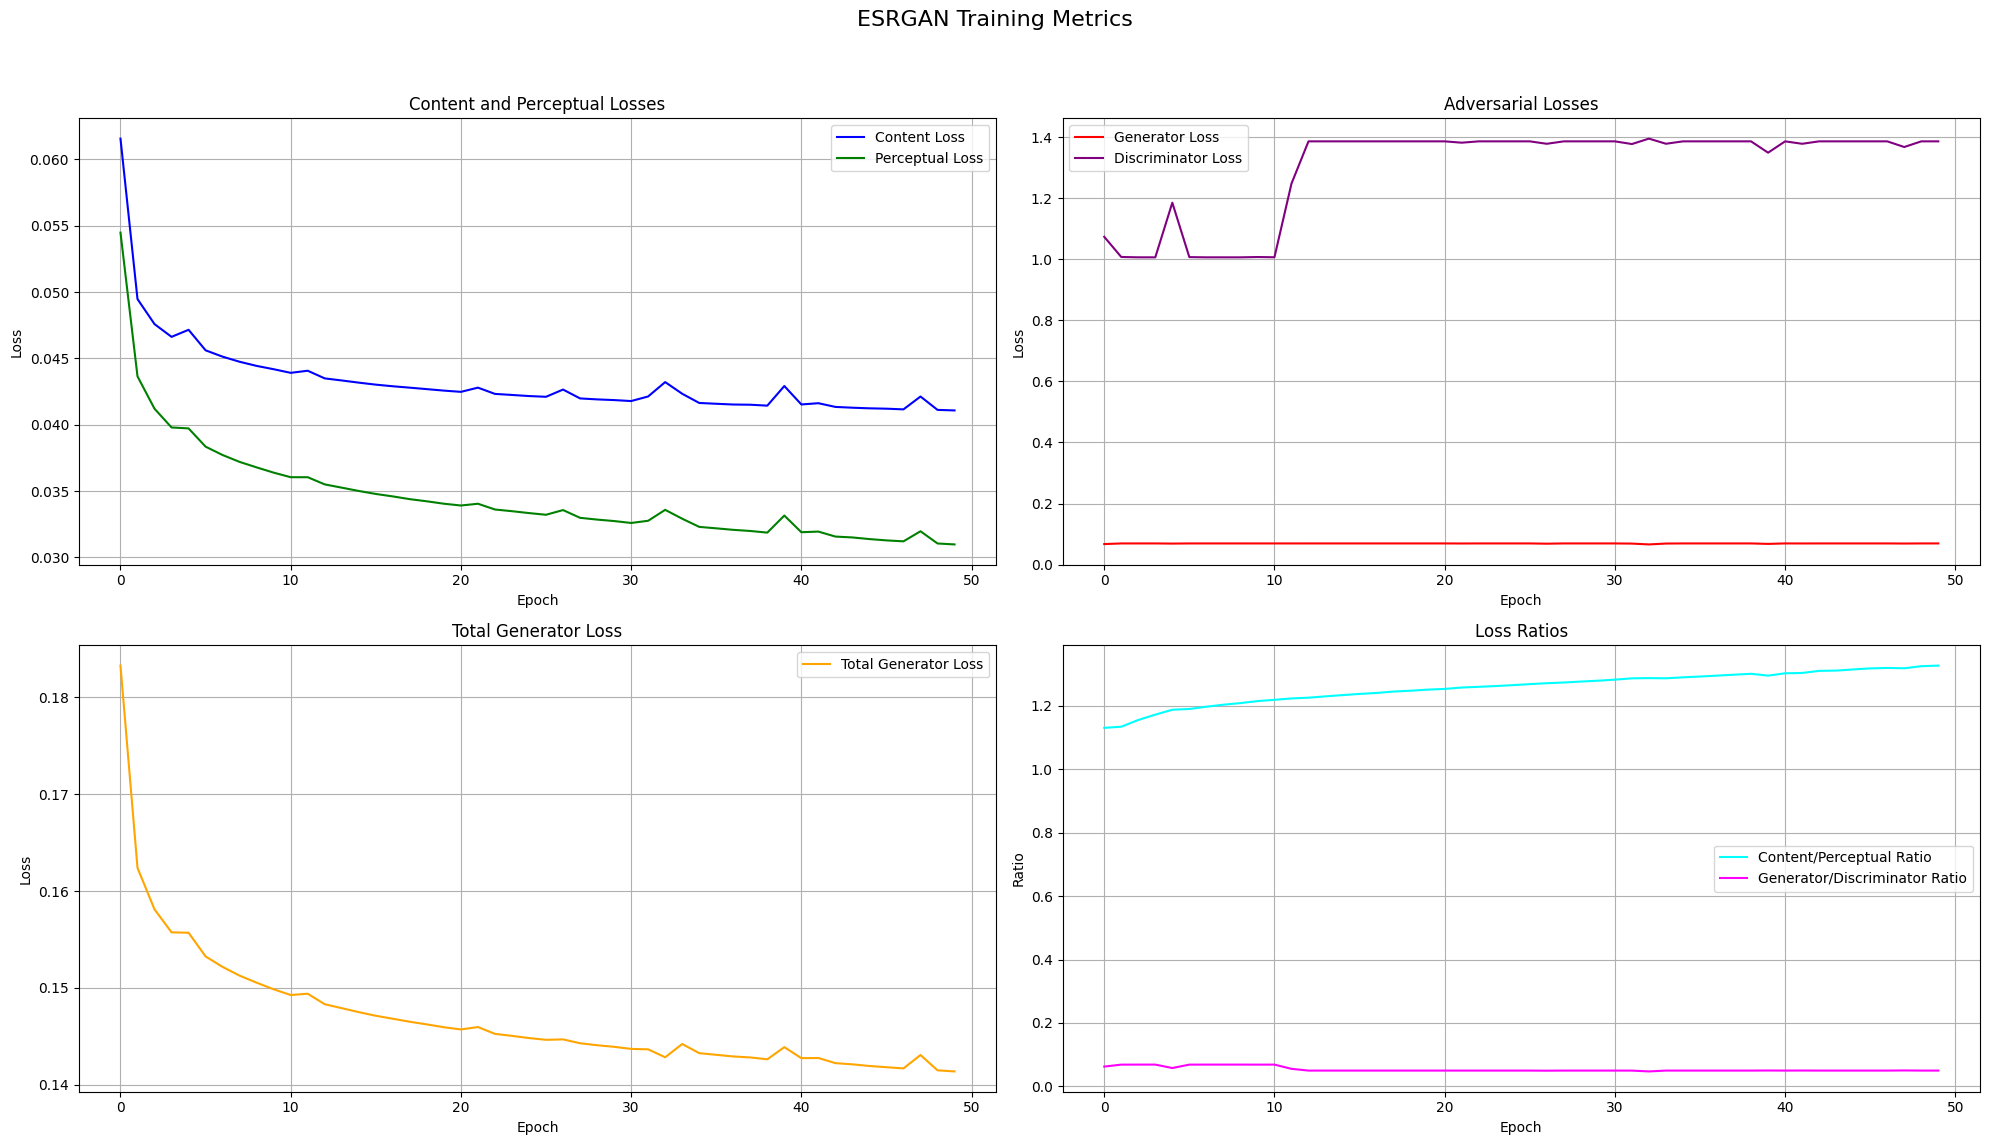

In [18]:
# Import and setup (make sure this is at the start of your script)
import tensorflow as tf
import os

# Your imports for ESRGAN and DataLoader here...

# Initialize model and data loader
model = ESRGAN(scale_factor=4)
model.compile(
    gen_lr=1e-4,
    disc_lr=1e-4,
    content_weight=1.0,
    perceptual_weight=1.0,
    adversarial_weight=0.1
)

data_loader = DataLoader(
    image_dir='/Users/osama/Developer/Deep Learning/GANs-Super-Resolution/Dataset/images',
    batch_size=4,
    hr_size=128,
    lr_size=32
)

# Start training
history = train_esrgan(model, data_loader, epochs=50, save_interval=5)

# Visualize results
visualizer = ESRGANVisualizer(save_dir='esrgan_visualizations')
visualizer.plot_training_history(history)

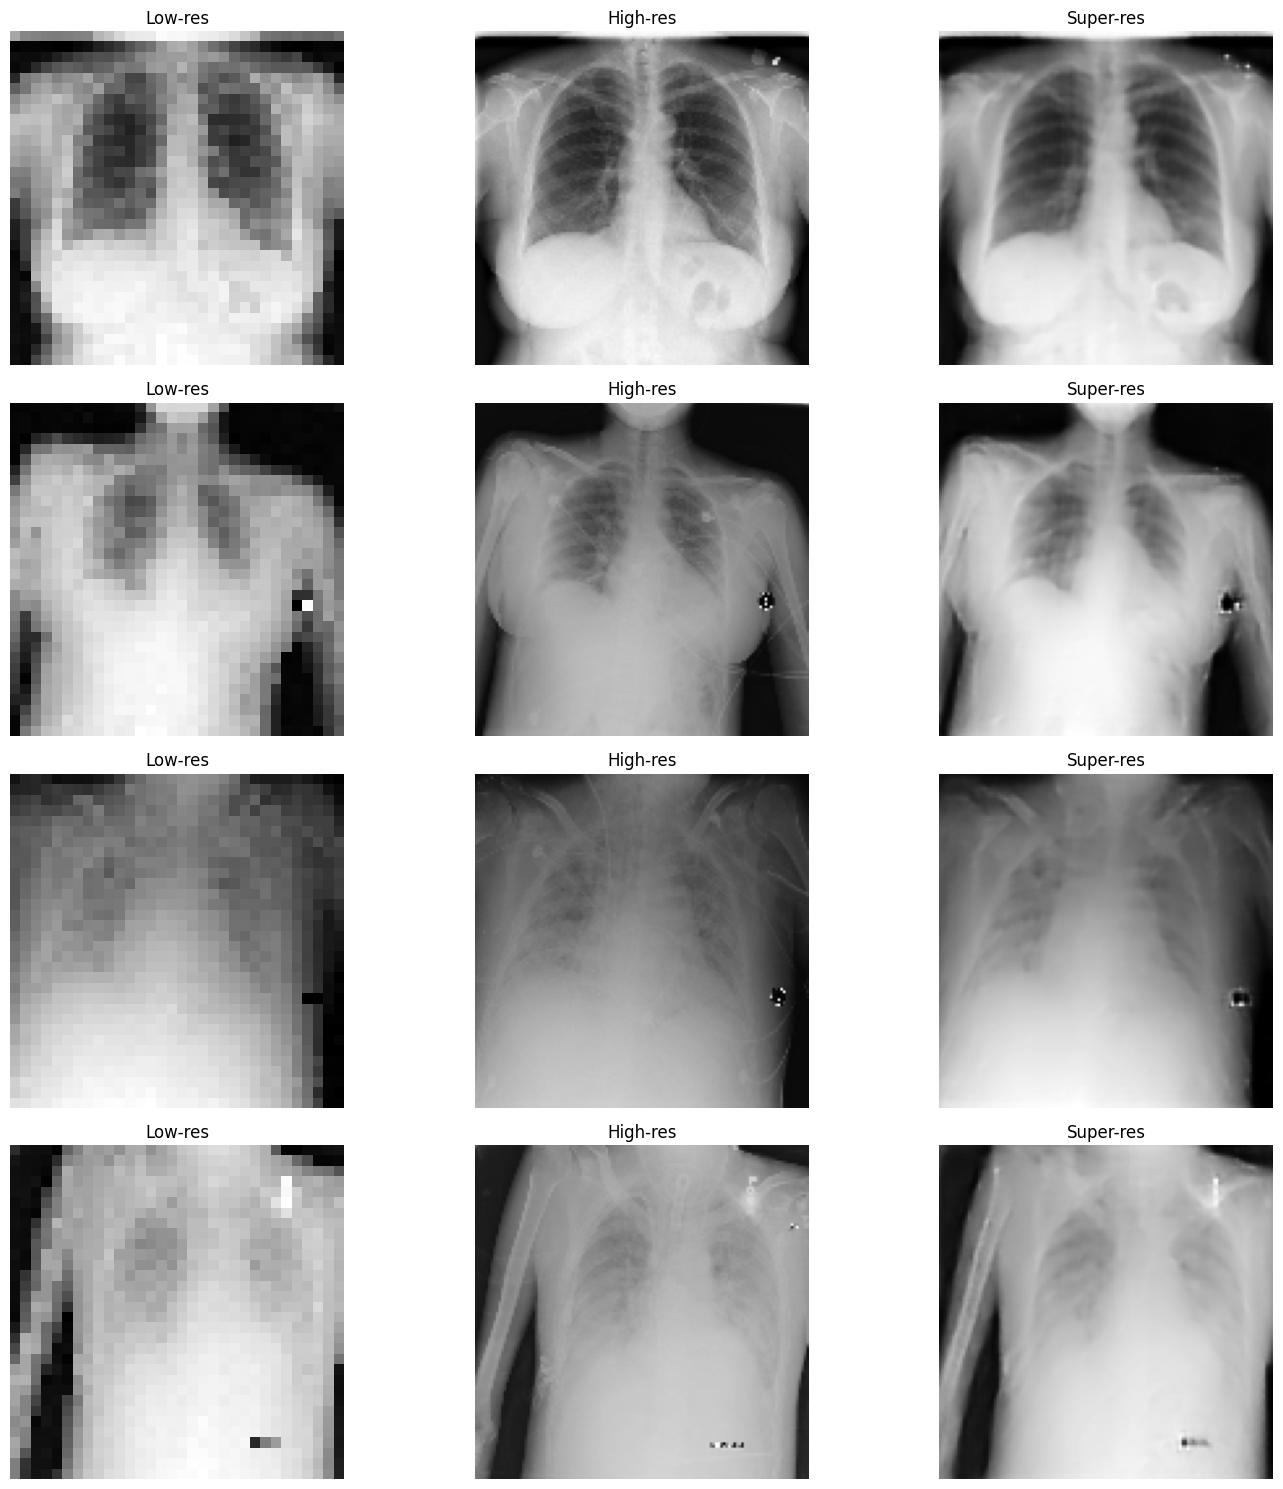

In [19]:

# Retrieve one batch from the dataset
for lr_images, hr_images in data_loader.dataset.take(1):  # Take a single batch
    # Generate super-resolution images
    sr_images = model.generator(lr_images, training=False)

    # Visualization
    plt.figure(figsize=(15, 15))
    for i in range(lr_images.shape[0]):  # Iterate over the batch
        # Low-resolution images
        plt.subplot(len(lr_images), 3, i * 3 + 1)
        plt.imshow(tf.squeeze((lr_images[i] + 1) / 2), cmap='gray')  # Rescale to [0, 1] for display
        plt.title('Low-res')
        plt.axis('off')
        
        # High-resolution images
        plt.subplot(len(lr_images), 3, i * 3 + 2)
        plt.imshow(tf.squeeze((hr_images[i] + 1) / 2), cmap='gray')  # Rescale to [0, 1] for display
        plt.title('High-res')
        plt.axis('off')
        
        # Super-resolution images
        plt.subplot(len(lr_images), 3, i * 3 + 3)
        plt.imshow(tf.squeeze((sr_images[i] + 1) / 2), cmap='gray')  # Rescale to [0, 1] for display
        plt.title('Super-res')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    break  # Process only one batch

In [20]:
for lr_images, hr_images in data_loader.dataset.take(1):
    print(hr_images[0].shape)
    break

(128, 128, 1)


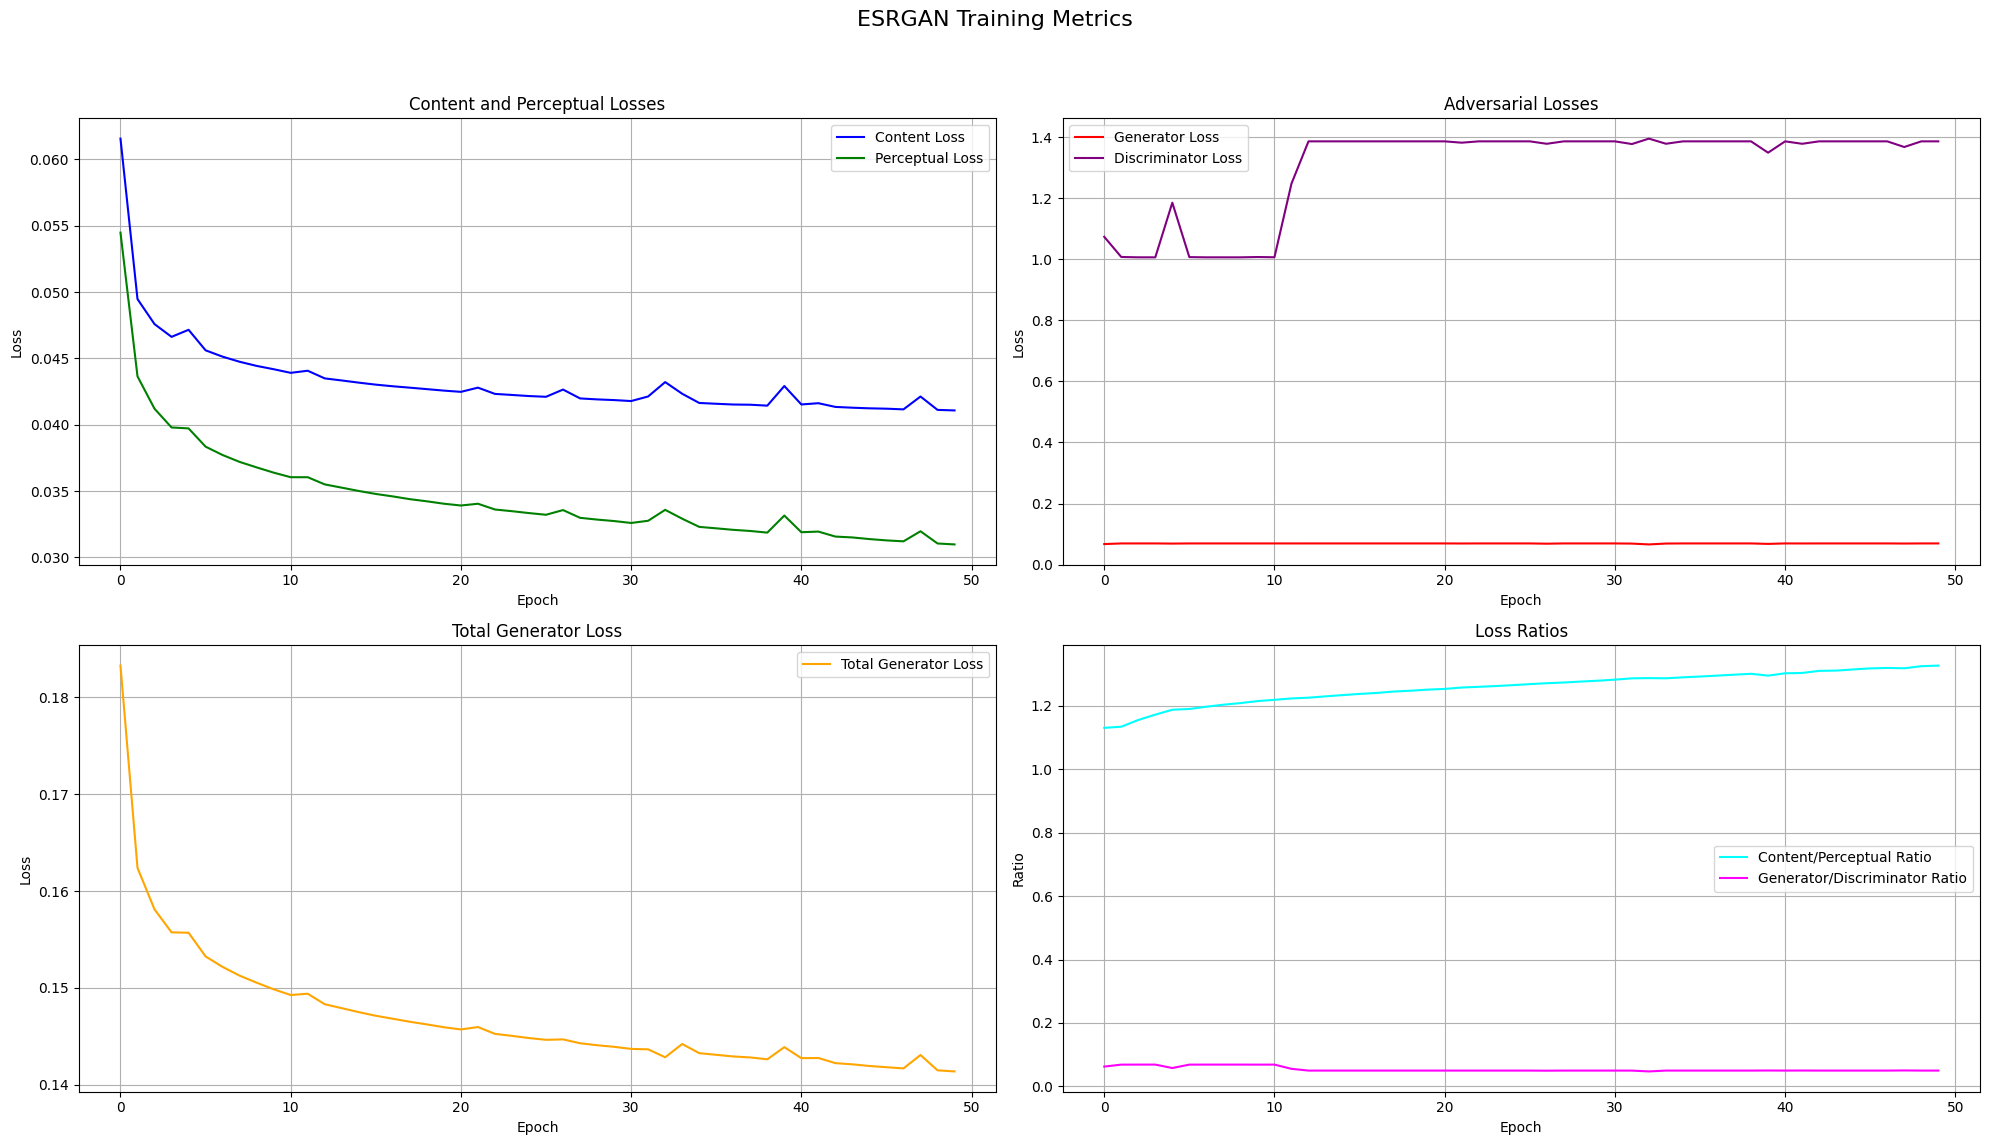

In [22]:
# Initialize the visualizer
visualizer = ESRGANVisualizer(save_dir='esrgan_visualizations')

# After training, create visualizations
visualizer.plot_training_history(history)
training_summary = visualizer.create_training_summary(history)

Mean PSNR: 27.7965
Mean SSIM: 0.8675
Mean MSE: 0.0020


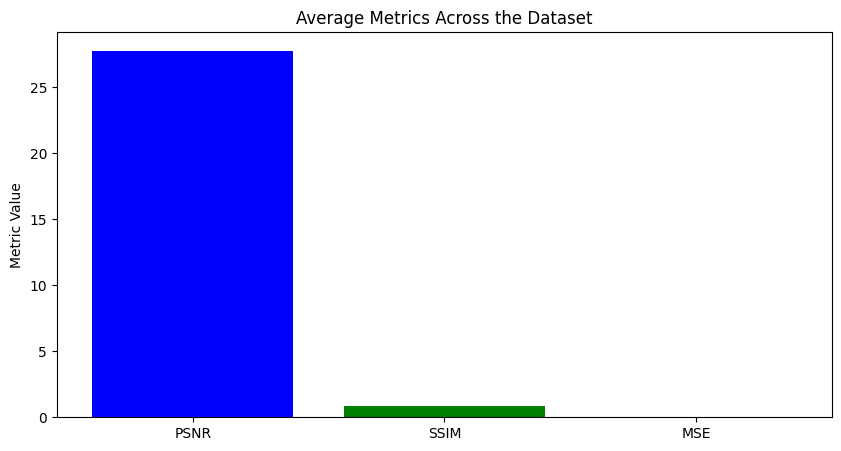

In [23]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error as mse
# Initialize variables to store cumulative metrics
cumulative_psnr = 0
cumulative_ssim = 0
cumulative_mse = 0
example_count = 0

# Loop through batches in the dataset
for lr_images, hr_images in data_loader.dataset:  # Dataset contains tuples of (lr_images, hr_images)
    # Generate super-resolution images for the current batch
    sr_images = model.generator(lr_images, training=False)

    # Loop through each image in the current batch
    batch_size = lr_images.shape[0]  # Get the batch size
    for i in range(batch_size):
        # Rescale images from [-1, 1] to [0, 1] for metric calculations
        hr_image = tf.squeeze((hr_images[i] + 1) / 2).numpy()
        sr_image = tf.squeeze((sr_images[i] + 1) / 2).numpy()

        # Calculate metrics for the current example
        psnr_value = psnr(hr_image, sr_image, data_range=1.0)
        ssim_value = ssim(hr_image, sr_image, data_range=1.0)
        mse_value = mse(hr_image, sr_image)

        # Accumulate metrics
        cumulative_psnr += psnr_value
        cumulative_ssim += ssim_value
        cumulative_mse += mse_value
        example_count += 1

# Calculate mean metrics across the entire dataset
if example_count == 0:
    print("No examples were processed. Please check your dataset.")
else:
    mean_psnr = cumulative_psnr / example_count
    mean_ssim = cumulative_ssim / example_count
    mean_mse = cumulative_mse / example_count

    # Print the results
    print(f"Mean PSNR: {mean_psnr:.4f}")
    print(f"Mean SSIM: {mean_ssim:.4f}")
    print(f"Mean MSE: {mean_mse:.4f}")

    # Visualization of metrics
    plt.figure(figsize=(10, 5))
    metrics = ['PSNR', 'SSIM', 'MSE']
    values = [mean_psnr, mean_ssim, mean_mse]

    plt.bar(metrics, values, color=['blue', 'green', 'red'])
    plt.ylabel('Metric Value')
    plt.title('Average Metrics Across the Dataset')
    plt.show()